# Visão Computacional End-to-End

## a) Pré-processamento

Separação dos canais de imagem e áudio

In [1]:
from pathlib import Path
from src import extract

input_video_path = Path("data/input_video.mp4")
image_channel_path = input_video_path.parent / "image_channel.mp4"
audio_channel_path = input_video_path.parent / "audio_channel.wav"

extract.split_audio_from_video(input_video_path, image_channel_path, audio_channel_path)

MoviePy - Writing audio in data\audio_channel.wav


MoviePy - Done.
MoviePy - Building video data\image_channel.mp4.
MoviePy - Writing video data\image_channel.mp4



frame_index:  92%|█████████▏| 900/981 [00:05<00:00, 170.94it/s, now=None]c:\Users\marilia.fernandez\.virtualenvs\teste-visao-Q7GtxB5W\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:190: UserWarning: In file data\input_video.mp4, 2764800 bytes wanted but 0 bytes read at frame index 901 (out of a total 981 frames), at time 30.03/32.72 sec. Using the last valid frame instead.
  warnings.warn(
c:\Users\marilia.fernandez\.virtualenvs\teste-visao-Q7GtxB5W\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:190: UserWarning: In file data\input_video.mp4, 2764800 bytes wanted but 0 bytes read at frame index 902 (out of a total 981 frames), at time 30.07/32.72 sec. Using the last valid frame instead.
  warnings.warn(
c:\Users\marilia.fernandez\.virtualenvs\teste-visao-Q7GtxB5W\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:190: UserWarning: In file data\input_video.mp4, 2764800 bytes wanted but 0 bytes read at frame index 903 (out of a total 981 frames), at time 30.10/32.72 sec. Using

MoviePy - Done !
MoviePy - video ready data\image_channel.mp4


## b) Armazenamento e Tratamento de Imagens

Extração de frames e metadados a cada 0,1 segundo

In [2]:
time_interval = 0.1  # tempo em segundos
frames, metadata = extract.extract_frames(image_channel_path, time_interval)

Armazenamento em banco de dados SQL local

In [3]:
from src import database

for frame, meta in zip(frames, metadata):
    hdu = extract.image_to_fits(frame, meta)
    database.insert_fits_data({
        "fits_data": hdu.data.tobytes(),
        "timestamp": hdu.header["TIME"],
        "frame_id": hdu.header["FRAME_ID"],
        'width': hdu.data.shape[1],
        'height': hdu.data.shape[0],
        'dtype': str(hdu.data.dtype),
    })

## c) Análise e Processamento de Imagens

Leitura das imagens do banco de dados

In [4]:
from src import database
data = database.load_fits_records()

Amostra para exemplificação 

Chaves: dict_keys(['id', 'fits_data', 'timestamp', 'frame_id', 'width', 'height', 'dtype', 'array'])


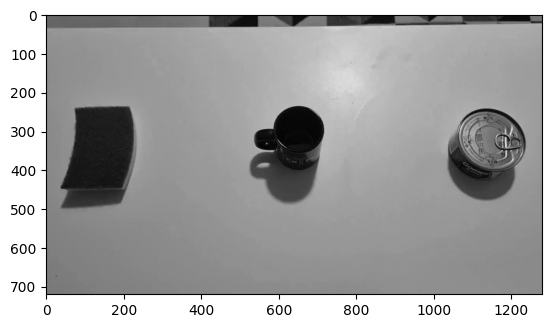

In [5]:
import matplotlib.pyplot as plt

amostra = data[0]
print("Chaves:", amostra.keys())
plt.imshow(amostra['array'], cmap='gray')

Equalização de histograma + plot do histograma

In [6]:
from src import image_operations
import matplotlib.pyplot as plt

output_histograms_dir = Path("data/histograms")
output_frames_dir = Path("data/frames")
output_histograms_dir.mkdir(parents=True, exist_ok=True)
output_frames_dir.mkdir(parents=True, exist_ok=True)

for record in data:
    image = record['array']
    image_operations.plot_histogram(image, output_path=output_histograms_dir / f"histogram_{record['frame_id']:04d}.png")
    image_equalized = image_operations.histogram_equalization(image)
    image_operations.plot_histogram(image_equalized, output_path=output_histograms_dir / f"histogram_equalized_{record['frame_id']:04d}.png")

    plt.imsave(output_frames_dir / f"frame_{record['frame_id']:04d}.png", image_equalized, cmap='gray')

Exemplo aplicado na amostra

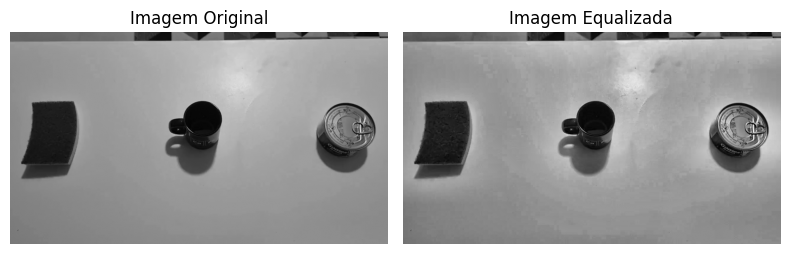

In [7]:
amostra_eq = image_operations.histogram_equalization(amostra['array'])

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

axes[0].imshow(amostra['array'], cmap='gray')
axes[0].set_title("Imagem Original")
axes[0].axis("off")

axes[1].imshow(amostra_eq, cmap='gray')
axes[1].set_title("Imagem Equalizada")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequência')

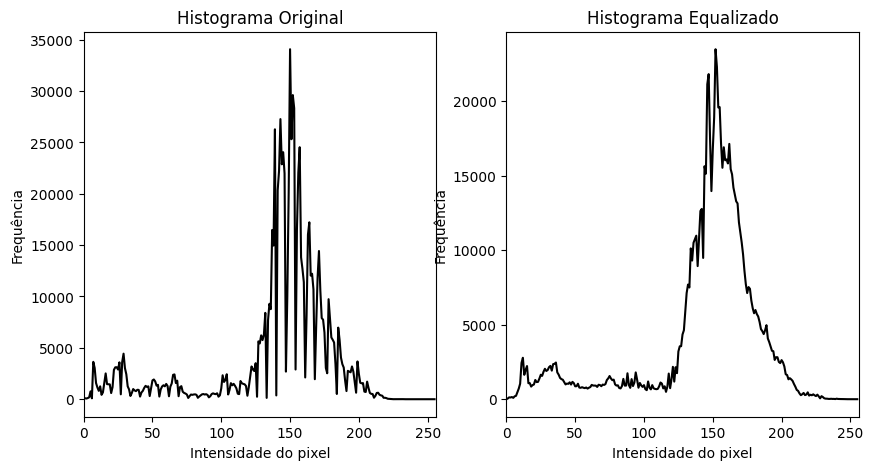

In [8]:
h1 = image_operations.histogram(amostra['array'])
h2 = image_operations.histogram(amostra_eq)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(h1, color='k')
plt.title("Histograma Original")
plt.xlim([0, 256])
plt.xlabel("Intensidade do pixel")
plt.ylabel("Frequência")

plt.subplot(1, 2, 2)
plt.plot(h2, color='k')
plt.title("Histograma Equalizado")
plt.xlim([0, 256])
plt.xlabel("Intensidade do pixel")
plt.ylabel("Frequência")

## d) Classificação com Machine Learning

Para a construção dos conjuntos de treino e teste, os frames foram segmentados e, em seguida, foi realizada uma etapa de curadoria manual, na qual imagens com falhas de segmentação foram descartadas. 

As amostras restantes foram anotadas com base em suas respectivas classes e armazenadas em `data/segmented`.

O processo de segmentação foi feito por meio de limirarização e identificação de contornos

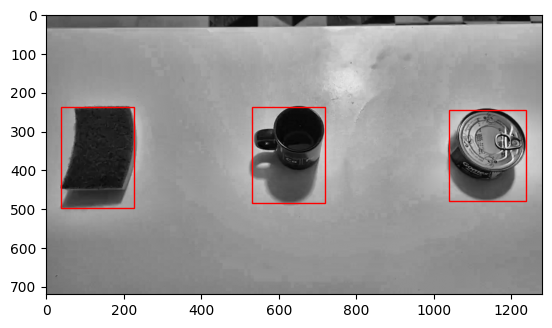

In [9]:
from src import bbox_operations

bboxes = bbox_operations.segmentation_boxes(amostra_eq)

for bbox in bboxes:
    x, y, w, h = bbox
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none'))
plt.imshow(amostra_eq, cmap='gray')


### d.1) Carregar o modelo treinado
Caso queria usar o modelo treinado pode executar esta célula e pular para a seção [d.5](#d5-predições-em-dez-amostras-aleatórias)

In [10]:
import joblib
# Carrega o modelo treinado
model = joblib.load('data/model.pkl')

### d.2) Leitura e engenharia de features

Leitura do dataset anotado e extração de features de `intensidade de pixel`, `cantos` e `arestas`

In [11]:
import cv2
labels = []
samples = []

for p in Path("data/segmented").glob("*.png"):
    frame_id, label, _ = p.stem.split('_')[1:]
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feat = image_operations.extract_features(img)
    samples.append(feat)
    labels.append(label)

In [12]:
from collections import Counter
print("Tamanho do vetor de features:", len(samples[0]))
print("Distribuição do dataset:", Counter(labels))

Tamanho do vetor de features: 16
Distribuição do dataset: Counter({'esponja': 66, 'caneca': 66, 'lata': 61})


### d.3) Treinamento

Separação do dataset entre treino e teste

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.25, random_state=42, shuffle=True)

print("Treinamento:", Counter(y_train))
print("Teste:", Counter(y_test))

Treinamento: Counter({'esponja': 52, 'caneca': 48, 'lata': 44})
Teste: Counter({'caneca': 18, 'lata': 17, 'esponja': 14})


Treinamento do modelo classificador SVM

In [14]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### d.4) Teste e Avaliação

              precision    recall  f1-score   support

      caneca       1.00      1.00      1.00        18
     esponja       1.00      1.00      1.00        14
        lata       1.00      1.00      1.00        17

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49



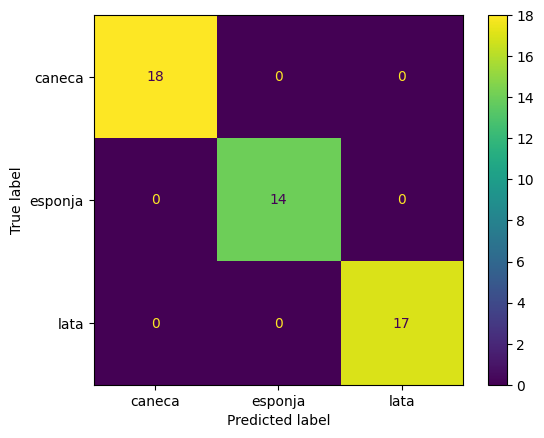

In [15]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))
cm = ConfusionMatrixDisplay.from_predictions(predicted, y_test, display_labels=model.classes_)

### d.5) Predições em dez amostras selecionadas

In [16]:
from src import image_operations
import cv2

ids = [182,  54,  39,  21, 216, 188, 100, 278,  21, 159]
labeled_images = []

color = {"esponja": (255, 0, 0), "caneca": (0, 255, 0), "lata": (0, 255, 255)}

for i in ids:
    d = data[i]
    img = image_operations.histogram_equalization(d["array"])
    segments_bbox = bbox_operations.segmentation_boxes(img)
    img_labeled = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for sb in segments_bbox:
        x, y, w, h = sb
        roi = img[y : y + h, x : x + w]  # Extrai apenas a região de interesse
        feat = image_operations.extract_features(roi)
        probs = model.predict_proba([feat])[0]
        predicted_label = model.classes_[probs.argmax()]

        img_labeled = bbox_operations.draw_boxes(
            img_labeled,
            x,
            y,
            w,
            h,
            f"{predicted_label.upper()}:{probs.max():.2f}",
            color[predicted_label],
        )

    labeled_images.append(img_labeled)

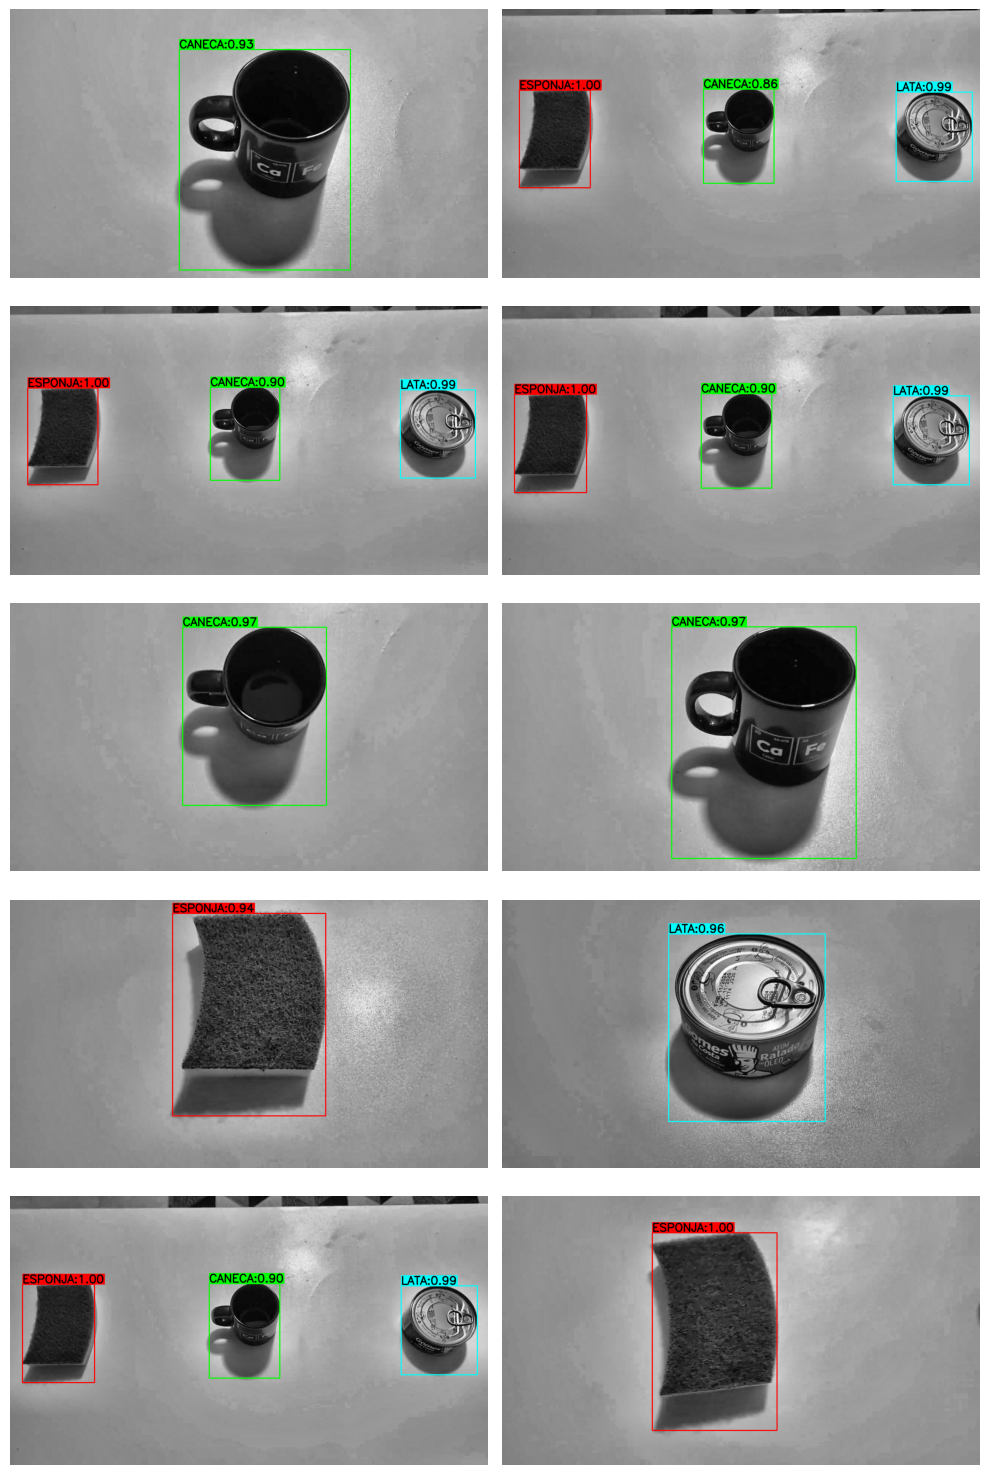

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5,2, figsize=(10, 15))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(labeled_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


## e) Análise de áudio

In [23]:
import whisper
model = whisper.load_model('medium')

In [24]:
transcription = model.transcribe('data/audio_channel.wav', fp16=False, language="pt", verbose=True)


[00:00.000 --> 00:11.600]  Temos aqui os três objetos. Primeiro aqui no canto uma esponja.
[00:17.360 --> 00:21.120]  Aqui no meio uma caneca.
[00:21.120 --> 00:29.040]  Por último uma lata de atum.


In [25]:
transcription['text']

' Temos aqui os três objetos. Primeiro aqui no canto uma esponja. Aqui no meio uma caneca. Por último uma lata de atum.'